In [295]:
import numpy as np
from pylab import *
import matplotlib
import matplotlib.pyplot as plt
import scipy.interpolate as interp
from mpl_toolkits.mplot3d import Axes3D

from propagation_functions import forwardpropagate, backpropagate
from helper_functions import get_Yhat

### Activation Functions ###

$$ sigmoid(Z) = \frac{1}{1 + e^{-Z}} $$
$$ tanh(Z) $$

In [296]:
def sigmoid(Z, return_derivative=False):
    if return_derivative:
        return np.multiply(sigmoid(Z), (1-sigmoid(Z)))
    else:
        return 1 / (1 + np.exp(-Z))


def tanh(Z, return_derivative=False):
    if return_derivative:
        return 1 - np.power(np.tanh(Z), 2)
    else:
        return np.tanh(Z)
    
    
def ReLU(Z, return_derivative=False):
    if return_derivative:
        return (Z > 0)
    else:
        return np.multiply(Z, (Z > 0))

### Logistic Cost Function (Unregularized) ###


$$J(W, X, Y) = - \frac{1}{m} \sum\limits_{k=1}^K\sum\limits_{i=1}^m Y_k^{(i)}log(h_{W}(x^{(i)})_k) + (1 - Y_k^{(i)} )log(1- h_W(x^{(i)})_k) $$

In [297]:
def compute_cost_logistic(Yhat, Y, return_derivative=False):
    assert (Yhat.shape == Y.shape)

    if return_derivative:
        return np.divide(1 - Y, 1 - Yhat) - np.divide(Y, Yhat)
    else:
        m = Y.shape[0]
        return (-1.0 / m) * np.sum(np.dot(Y.T, np.log(Yhat)) + np.dot((1-Y).T, np.log(1-Yhat)))
    

def get_accuracy(Yhat, Y):
    predictions = (Yhat > 0.5)
    correct = (predictions == Y)
    return np.mean(correct)

In [298]:
def generate_data_set(m, layer_dims):
    n_x = layer_dims[0]
    n_y = layer_dims[-1]
    X = np.random.randint(30, size=(m, n_x))
    Y = np.multiply(X[:, [0]], X[:, [1]]) % 2 == 0
    
    assert(X.shape == (m, n_x))
    assert(Y.shape == (m, n_y))
    return X, Y

In [299]:
def initialize_parameters(layer_dims, scale_term=0.1):
    parameters = {}
    for i in range(1, len(layer_dims)):
        parameters["W" + str(i)] = np.random.randn(layer_dims[i], layer_dims[i - 1]) * scale_term
        parameters["b" + str(i)] = np.zeros((layer_dims[i], 1))

    return parameters

In [300]:
def model_nn(X, Y, layer_dims, activation_functions, cost_function, learning_rate=0.005, num_iterations=20, scale_term=0.1):
    parameters = initialize_parameters(layer_dims)
    num_layers = len(activation_functions)

    for i in range(num_iterations):
        outputs = forwardpropagate(X, parameters, activation_functions)
        gradients = backpropagate(outputs, parameters, activation_functions, Y, cost_function)
        for layer in range(1, num_layers+1):
            parameters["W" + str(layer)] -= learning_rate * gradients["dW" + str(layer)]
            parameters["b" + str(layer)] -= learning_rate * gradients["db" + str(layer)]

    return parameters

In [301]:
# NN settings
learning_rate = 0.005
scale_term = 0.05
n_x = 2
n_h = 3
n_y = 1
activation_functions = {"g1": tanh,
                      "g2": sigmoid}
layer_dims = [n_x, n_h, n_y]

# CV settings
num_cv_cases = 20
X_cv, Y_cv = generate_data_set(num_cv_cases, layer_dims)

# Iteration Settings
min_mtrain = 100
max_mtrain = 600
min_iterations = 100
max_iterations = 400
step_size = 50


In [302]:

iteration_vals, mtrain_vals, train_cost_vals, cv_cost_vals, accuracy_vals = ([] for i in range(5))

parameters = {}
for m in range(min_mtrain, max_mtrain, step_size):
    X_train, Y_train = generate_data_set(m, layer_dims)
    for i in range(min_iterations, max_iterations, step_size):
        parameters = model_nn(X_train, Y_train, layer_dims, activation_functions, compute_cost_logistic, learning_rate, i, scale_term)
        
        Yhat_train = get_Yhat(X_train, parameters, activation_functions)
        Yhat_cv = get_Yhat(X_cv, parameters, activation_functions)
        
        train_cost = compute_cost_logistic(Yhat_train, Y_train)
        cv_cost = compute_cost_logistic(Yhat_cv, Y_cv)
        
        accuracy = get_accuracy(Yhat_cv, Y_cv)
        
        iteration_vals.append(i)
        mtrain_vals.append(m)
        train_cost_vals.append(train_cost)
        cv_cost_vals.append(cv_cost)
        accuracy_vals.append(accuracy)

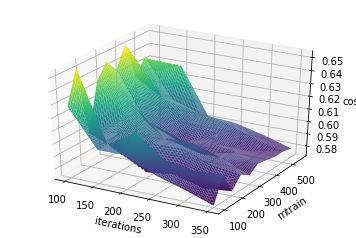

In [303]:
X = iteration_vals
Y = mtrain_vals
Z = cv_cost_vals

plotx,ploty, = np.meshgrid(np.linspace(np.min(X),np.max(X),100), np.linspace(np.min(Y),np.max(Y),100))
plotz = interp.griddata((X,Y),Z,(plotx,ploty),method='linear')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(plotx,ploty,plotz,cstride=1,rstride=1,cmap='viridis')  # or 'hot'
ax.set_xlabel("iterations")
ax.set_ylabel("mtrain")
ax.set_zlabel("cost")

plt.show()

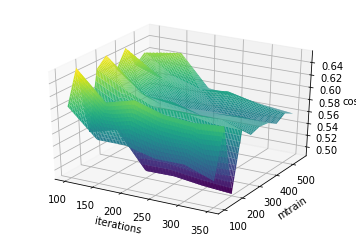

In [304]:
Z = train_cost_vals

plotx,ploty, = np.meshgrid(np.linspace(np.min(X),np.max(X),100), np.linspace(np.min(Y),np.max(Y),100))
plotz = interp.griddata((X,Y),Z,(plotx,ploty),method='linear')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(plotx,ploty,plotz,cstride=1,rstride=1,cmap='viridis')  # or 'hot'
ax.set_xlabel("iterations")
ax.set_ylabel("mtrain")
ax.set_zlabel("cost")

plt.show()